# Midterm Project

## Imports

In [75]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.ensemble import RandomForestRegressor

## Data Preparation

### Importing Dataset

In [76]:
df = pd.read_csv('full_dataset.csv')

In [77]:
df.dtypes

matchId         object
queueId          int64
gameVersion     object
teamId           int64
role            object
champion        object
gold_14          int64
xp_14            int64
kills_14         int64
deaths_14        int64
assists_14       int64
plates_14        int64
towers_14        int64
dragons_14       int64
heralds_14       int64
grubs_14         int64
gold_20          int64
xp_20            int64
damage_20      float64
win               bool
gold_growth      int64
xp_growth        int64
kda_14         float64
dtype: object

### Preliminary Cleaning

In [78]:
# Standardize columns and string data
df.columns = df.columns.str.lower()

# Standardize string values
string_columns = list(df.dtypes[df.dtypes == 'object'].index)
for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')
    
# Handle missing numeric values
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols] = df[numeric_cols].fillna(0)

In [79]:
df

,matchid,queueid,gameversion,teamid,role,champion,gold_14,xp_14,kills_14,deaths_14,...,dragons_14,heralds_14,grubs_14,gold_20,xp_20,damage_20,win,gold_growth,xp_growth,kda_14
0,euw1_7391567515,420,15.9.678.1456,100,top,kennen,5758,6739,5,2,...,1,0,0,9252,10317,168.26,False,3494,3578,2.666667
1,euw1_7391567515,420,15.9.678.1456,100,jungle,gwen,4528,4933,2,3,...,1,0,0,8285,9120,111.26,False,3757,4187,0.750000
2,euw1_7391567515,420,15.9.678.1456,100,mid,velkoz,4667,6811,1,2,...,1,0,0,7138,10182,143.76,False,2471,3371,0.666667
3,euw1_7391567515,420,15.9.678.1456,100,adc,draven,5348,5531,2,2,...,1,0,0,9767,8954,113.86,False,4419,3423,0.666667
4,euw1_7391567515,420,15.9.678.1456,100,support,leona,3306,2599,1,3,...,1,0,0,5342,5373,3810.00,False,2036,2774,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126725,euw1_7414672500,420,15.10.680.4378,200,top,rumble,5304,7072,5,2,...,0,0,0,7008,9470,144.22,True,1704,2398,1.666667
126726,euw1_7414672500,420,15.10.680.4378,200,jungle,pantheon,5176,5073,3,3,...,0,0,0,8758,9092,9393.00,True,3582,4019,1.250000
126727,euw1_7414672500,420,15.10.680.4378,200,mid,yasuo,4699,6378,1,2,...,0,0,0,7592,10744,4788.00,True,2893,4366,1.000000
126728,euw1_7414672500,420,15.10.680.4378,200,adc,jhin,6074,4762,6,1,...,0,0,0,9666,8504,149.53,True,3592,3742,4.500000


In [80]:
# Check which numeric columns are all zeros and could be safely removed
all_zero_cols = [col for col in numeric_cols if (df[col] == 0).all()]

print("Numeric columns with all zero values:")
print(all_zero_cols)

Numeric columns with all zero values:
['heralds_14', 'grubs_14']


### Feature Engineering/Aggregation

In [81]:
roles = ['top', 'jungle', 'mid', 'adc', 'support']
stats = ['gold_14', 'xp_14', 'kda_14']
objectives = ['dragons_14', 'towers_14', 'plates_14']

In [82]:
def pivot_team(team_df, prefix):
        team_pivot = pd.DataFrame({'matchid': team_df['matchid'].unique()})
        
        # Per-role data
        for role in roles:
            role_df = team_df[team_df['role'] == role].copy()
            role_df = role_df[['matchid', 'champion'] + stats]
            
            rename_dict = {'champion': f'champion_{role}_{prefix}'}
            rename_dict.update({stat: f'{stat}_{role}_{prefix}' for stat in stats})
            role_df = role_df.rename(columns=rename_dict)
            
            team_pivot = team_pivot.merge(role_df, on='matchid', how='left')
        
        # Team objectives
        for obj in objectives:
            obj_df = team_df.groupby('matchid')[obj].first().reset_index()
            obj_df = obj_df.rename(columns={obj: f'{obj}_{prefix}'})
            team_pivot = team_pivot.merge(obj_df, on='matchid', how='left')
        
        return team_pivot

In [83]:
def build_team_cols(prefix):
        cols = []
        for role in roles:
            cols.append(f'champion_{role}_{prefix}')
            for stat in stats:
                cols.append(f'{stat}_{role}_{prefix}')
        for obj in objectives:
            cols.append(f'{obj}_{prefix}')
        return cols

In [84]:
def build_match_dataset(df):
    """
    Convert a player-level dataset into a match-level dataset,
    preserving per-role stats and champions for both teams.
    Team assignment is based on teamid (100 = blue, 200 = red).
    """

    # --- Split teams ---
    blue_team = df[df['teamid'] == 100].copy()
    red_team  = df[df['teamid'] == 200].copy()

    # --- Pivot ---
    blue_team_pivot = pivot_team(blue_team, 'blue')
    red_team_pivot  = pivot_team(red_team, 'red')

    # --- Merge teams ---
    match_df = pd.merge(blue_team_pivot, red_team_pivot, on='matchid', how='inner')

    # --- Compute diffs ---
    for role in roles:
        for stat in stats:
            blue_col = f'{stat}_{role}_blue'
            red_col  = f'{stat}_{role}_red'
            match_df[f'{stat}_{role}_diff'] = match_df[blue_col] - match_df[red_col]
            
    for obj in objectives:
        blue_col = f'{obj}_blue'
        red_col  = f'{obj}_red'
        match_df[f'{obj}_diff'] = match_df[blue_col] - match_df[red_col]

    # --- Target variable ---
    match_df['win'] = df.groupby('matchid')['win'].first().astype(int).values

    # --- Keep only champions, diffs, matchid, win ---
    champ_cols = [f'champion_{role}_blue' for role in roles] + [f'champion_{role}_red' for role in roles]
    diff_cols  = [col for col in match_df.columns if col.endswith('_diff')]
    final_cols = ['matchid'] + champ_cols + diff_cols + ['win']

    return match_df[final_cols]

In [85]:
match_df = build_match_dataset(df)

In [86]:
match_df.dtypes

matchid                   object
champion_top_blue         object
champion_jungle_blue      object
champion_mid_blue         object
champion_adc_blue         object
champion_support_blue     object
champion_top_red          object
champion_jungle_red       object
champion_mid_red          object
champion_adc_red          object
champion_support_red      object
gold_14_top_diff           int64
xp_14_top_diff             int64
kda_14_top_diff          float64
gold_14_jungle_diff        int64
xp_14_jungle_diff          int64
kda_14_jungle_diff       float64
gold_14_mid_diff           int64
xp_14_mid_diff             int64
kda_14_mid_diff          float64
gold_14_adc_diff           int64
xp_14_adc_diff             int64
kda_14_adc_diff          float64
gold_14_support_diff       int64
xp_14_support_diff         int64
kda_14_support_diff      float64
dragons_14_diff            int64
towers_14_diff             int64
plates_14_diff             int64
win                        int64
dtype: obj

### Finalized DataFrames

In [87]:
df_full_train, df_test = train_test_split(match_df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [88]:
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [89]:
y_train = df_train.win.values
y_val = df_val.win.values
y_test = df_test.win.values

del df_train['win']
del df_val['win']
del df_test['win']

In [90]:
df_train

,matchid,champion_top_blue,champion_jungle_blue,champion_mid_blue,champion_adc_blue,champion_support_blue,champion_top_red,champion_jungle_red,champion_mid_red,champion_adc_red,...,kda_14_mid_diff,gold_14_adc_diff,xp_14_adc_diff,kda_14_adc_diff,gold_14_support_diff,xp_14_support_diff,kda_14_support_diff,dragons_14_diff,towers_14_diff,plates_14_diff
0,euw1_7366491252,tryndamere,leesin,vladimir,corki,bard,gragas,zed,veigar,fiora,...,6.666667,2385,1537,5.333333,163,418,1.085714,0,1,4
1,euw1_7339490878,gragas,viego,azir,ezreal,leona,gnar,pantheon,taliyah,caitlyn,...,3.666667,-394,-177,-0.666667,-703,-289,0.750000,-2,0,-5
2,euw1_7385824819,mordekaiser,karthus,viego,jhin,bard,jayce,leesin,irelia,kaisa,...,1.642857,-1913,-26,-0.900000,1564,443,2.666667,-1,0,-5
3,euw1_7406036559,rumble,viego,ahri,nilah,taric,aatrox,pantheon,syndra,ashe,...,0.200000,976,1147,1.333333,331,931,4.250000,-1,1,9
4,euw1_7388330888,kennen,shen,yone,lucian,nami,yorick,naafiri,azir,kaisa,...,-2.000000,2044,755,2.500000,-264,-594,0.750000,1,0,-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7598,euw1_7405290943,trundle,talon,akali,kaisa,janna,yorick,nunu,qiyana,twitch,...,-1.000000,-2205,-806,-2.833333,-1142,-1532,-4.500000,-1,0,0
7599,euw1_7412026291,sion,taliyah,jayce,zilean,bard,yorick,karthus,yone,corki,...,2.000000,738,752,2.000000,408,1048,2.500000,-1,0,4
7600,euw1_7405700109,vladimir,nocturne,orianna,aphelios,rell,nidalee,naafiri,ahri,lucian,...,0.550000,-1255,-1215,-1.166667,328,-400,0.833333,-1,1,4
7601,euw1_7402129649,jayce,karthus,akali,jhin,rell,viktor,leesin,talon,xerath,...,0.333333,1887,764,7.000000,690,643,6.000000,2,0,2


## Exploratory Data Analysis

### Basic Data Checks

In [91]:
df_full_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10138 entries, 0 to 10137
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   matchid                10138 non-null  object 
 1   champion_top_blue      10138 non-null  object 
 2   champion_jungle_blue   10138 non-null  object 
 3   champion_mid_blue      10138 non-null  object 
 4   champion_adc_blue      10138 non-null  object 
 5   champion_support_blue  10138 non-null  object 
 6   champion_top_red       10138 non-null  object 
 7   champion_jungle_red    10138 non-null  object 
 8   champion_mid_red       10138 non-null  object 
 9   champion_adc_red       10138 non-null  object 
 10  champion_support_red   10138 non-null  object 
 11  gold_14_top_diff       10138 non-null  int64  
 12  xp_14_top_diff         10138 non-null  int64  
 13  kda_14_top_diff        10138 non-null  float64
 14  gold_14_jungle_diff    10138 non-null  int64  
 15  xp

In [92]:
df_full_train.describe()

,gold_14_top_diff,xp_14_top_diff,kda_14_top_diff,gold_14_jungle_diff,xp_14_jungle_diff,kda_14_jungle_diff,gold_14_mid_diff,xp_14_mid_diff,kda_14_mid_diff,gold_14_adc_diff,xp_14_adc_diff,kda_14_adc_diff,gold_14_support_diff,xp_14_support_diff,kda_14_support_diff,dragons_14_diff,towers_14_diff,plates_14_diff,win
count,10138.000000,10138.000000,10138.000000,10138.000000,10138.000000,10138.000000,10138.000000,10138.000000,10138.000000,10138.000000,10138.000000,10138.000000,10138.000000,10138.000000,10138.000000,10138.000000,10138.000000,10138.000000,10138.000000
mean,75.917439,29.570823,0.159585,63.415565,50.566088,0.174110,28.866542,9.617282,0.078141,35.287039,7.480568,0.042378,31.492109,11.579010,0.086457,-0.324620,0.045177,0.251332,0.534524
std,1284.651011,1120.441442,2.193487,1067.030492,903.862361,3.399994,1095.265495,886.642951,2.717871,1259.095455,813.409594,2.848581,727.981443,651.010397,3.266459,1.153362,0.704648,4.395393,0.498831
min,-5763.000000,-4387.000000,-14.700000,-4350.000000,-3559.000000,-17.000000,-7285.000000,-4422.000000,-15.500000,-5215.000000,-4485.000000,-14.666667,-3674.000000,-2564.000000,-18.444444,-2.000000,-6.000000,-15.000000,0.000000
25%,-788.000000,-713.000000,-1.000000,-646.750000,-545.750000,-1.666667,-672.750000,-568.000000,-1.333333,-782.000000,-532.000000,-1.428571,-425.000000,-413.000000,-1.500000,-1.000000,0.000000,-3.000000,0.000000
50%,75.000000,32.500000,0.000000,63.000000,51.000000,0.000000,37.500000,0.000000,0.000000,25.500000,2.500000,0.000000,33.000000,15.000000,0.000000,-1.000000,0.000000,0.000000,1.000000
75%,946.750000,784.000000,1.250000,769.000000,644.000000,2.000000,723.750000,599.000000,1.500000,852.000000,548.000000,1.500000,478.000000,444.000000,1.700000,1.000000,0.000000,3.000000,1.000000
max,5559.000000,4322.000000,12.000000,4185.000000,4077.000000,18.500000,4453.000000,3297.000000,14.200000,6622.000000,3856.000000,16.500000,3433.000000,2515.000000,17.666667,2.000000,4.000000,14.000000,1.000000


In [93]:
df_full_train.isna().sum().sort_values(ascending=False)

matchid                  0
champion_top_blue        0
champion_jungle_blue     0
champion_mid_blue        0
champion_adc_blue        0
champion_support_blue    0
champion_top_red         0
champion_jungle_red      0
champion_mid_red         0
champion_adc_red         0
champion_support_red     0
gold_14_top_diff         0
xp_14_top_diff           0
kda_14_top_diff          0
gold_14_jungle_diff      0
xp_14_jungle_diff        0
kda_14_jungle_diff       0
gold_14_mid_diff         0
xp_14_mid_diff           0
kda_14_mid_diff          0
gold_14_adc_diff         0
xp_14_adc_diff           0
kda_14_adc_diff          0
gold_14_support_diff     0
xp_14_support_diff       0
kda_14_support_diff      0
dragons_14_diff          0
towers_14_diff           0
plates_14_diff           0
win                      0
dtype: int64

### Distribution Analysis

Text(0.5, 0.98, 'Distributions of Numerical Features')

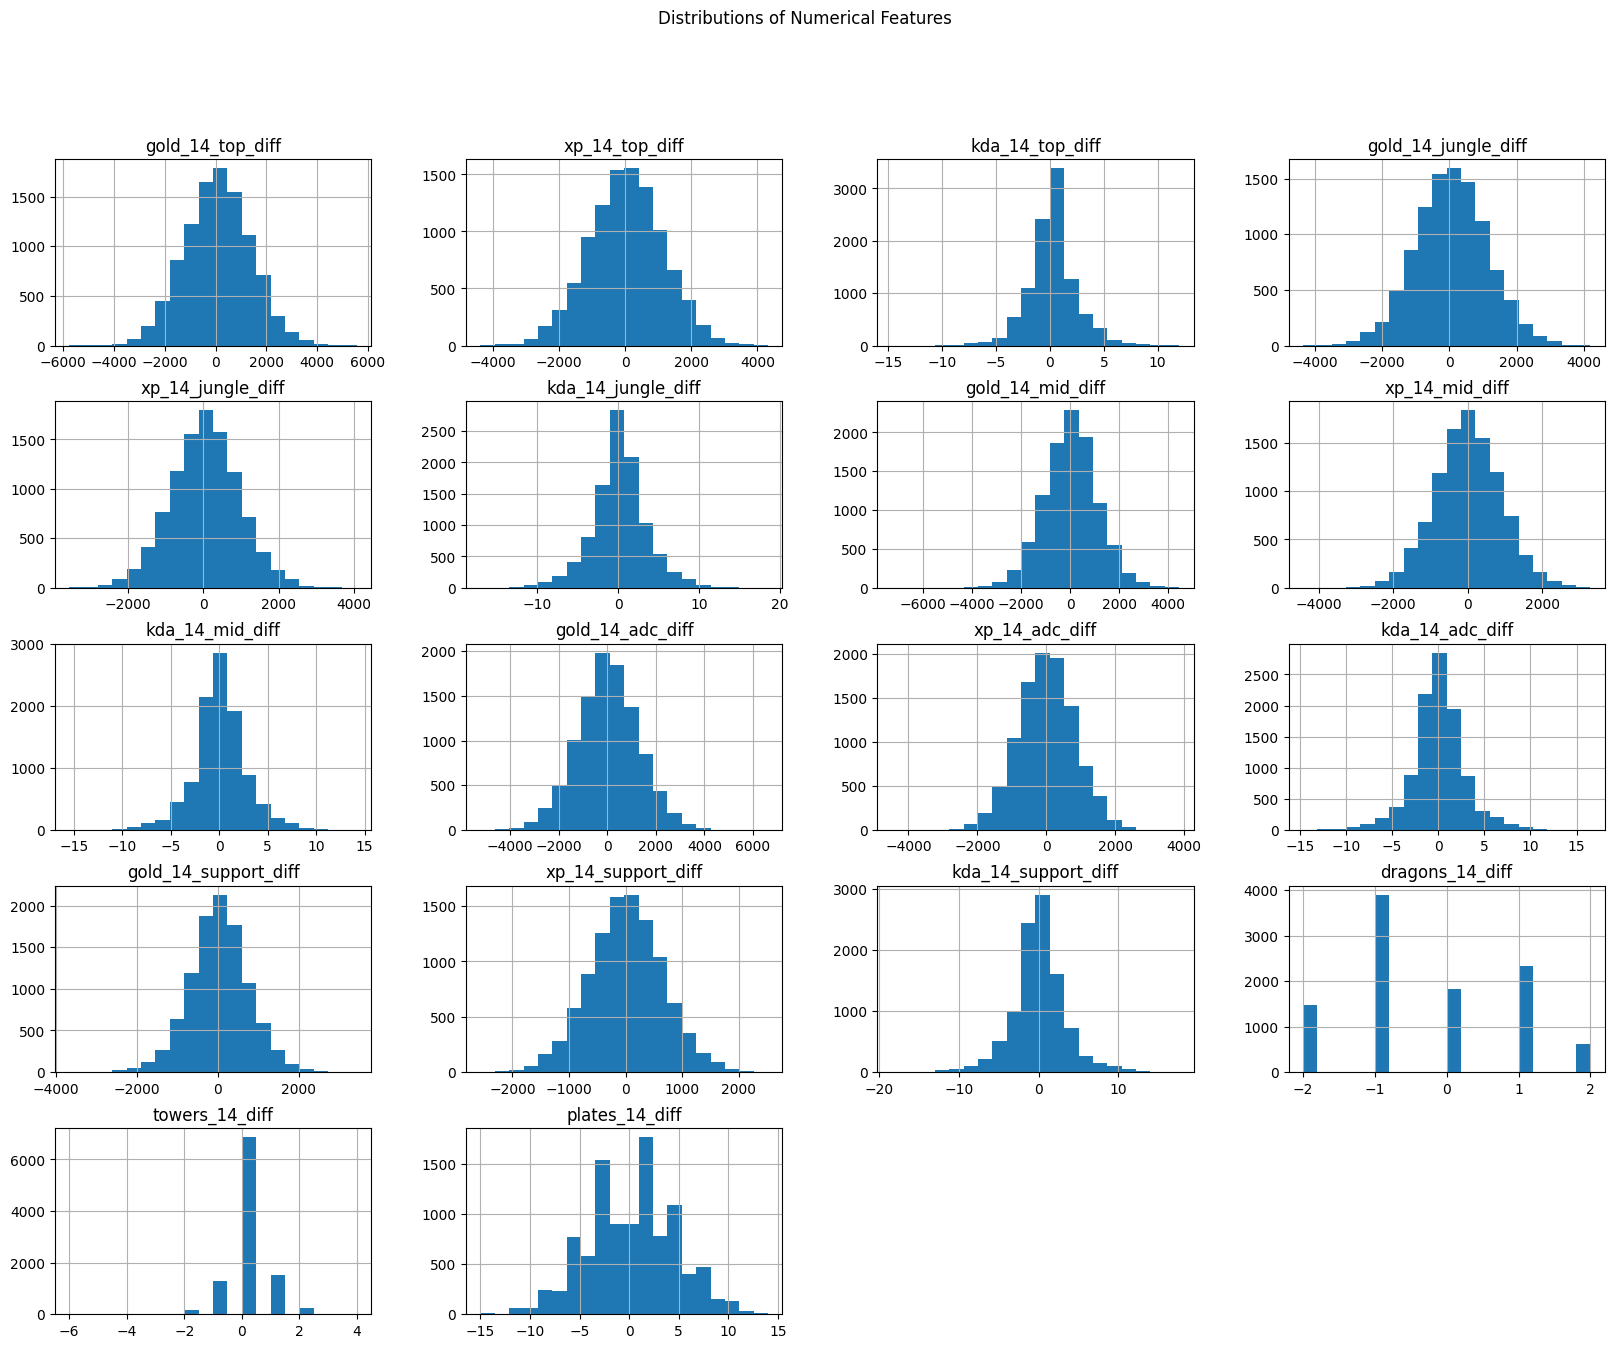

In [94]:
numeric_cols = [col for col in df_full_train.columns if df_full_train[col].dtype != 'object' and col not in ['win']]
df_full_train[numeric_cols].hist(figsize=(20,15), bins=20)
plt.suptitle("Distributions of Numerical Features")

### Target Variable Balance

In [98]:
df_full_train.win.value_counts(normalize=True)

win
1    0.534524
0    0.465476
Name: proportion, dtype: float64

In [100]:
df_full_train.win.mean()

np.float64(0.53452357466956)

Text(0, 0.5, 'Proportion')

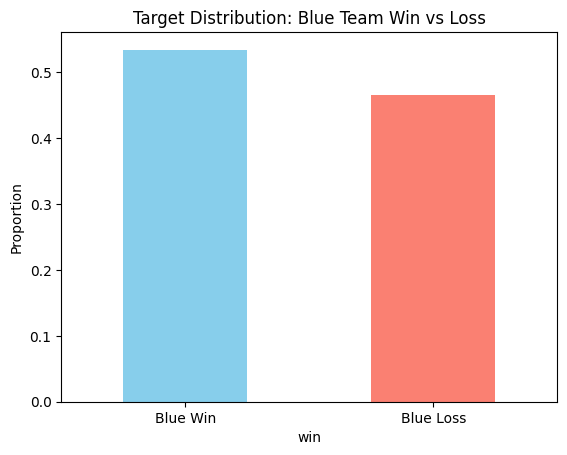

In [101]:
df_full_train['win'].value_counts(normalize=True).plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Target Distribution: Blue Team Win vs Loss")
plt.xticks([0, 1], ['Blue Win', 'Blue Loss'], rotation=0)
plt.ylabel("Proportion")

In [104]:
categorical = df_full_train.select_dtypes(include='object').columns.tolist()

In [105]:
df_full_train[categorical].nunique()

matchid                  10138
champion_top_blue          135
champion_jungle_blue        82
champion_mid_blue          134
champion_adc_blue           95
champion_support_blue      106
champion_top_red           138
champion_jungle_red         76
champion_mid_red           133
champion_adc_red           101
champion_support_red        98
dtype: int64

### Feature Importance

### Feature Correlation

Text(0.5, 1.0, 'Feature Correlation Heatmap')

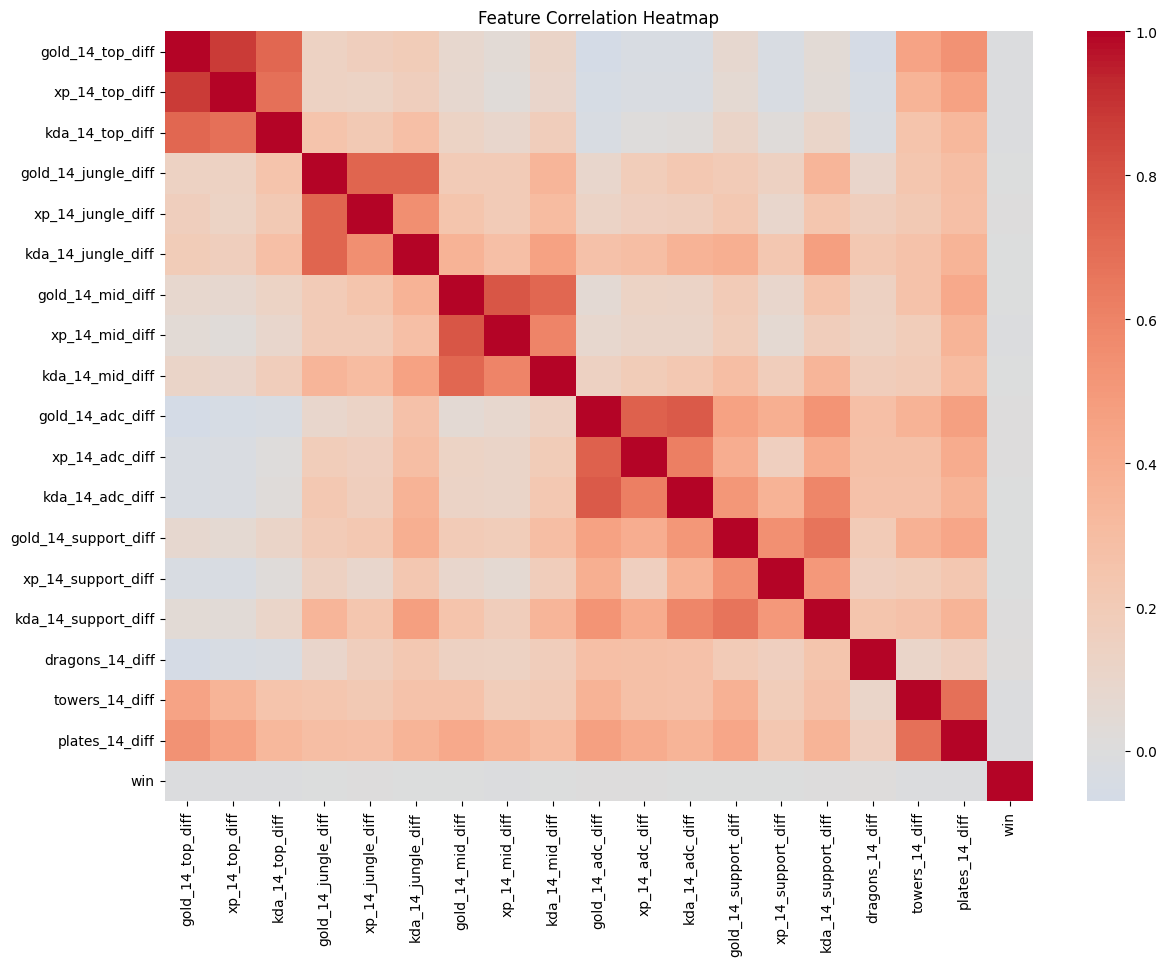

In [96]:
corr = df_full_train.corr(numeric_only=True)
plt.figure(figsize=(14,10))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title("Feature Correlation Heatmap")

In [97]:
corr['win'].sort_values(ascending=False)

win                     1.000000
dragons_14_diff         0.011508
xp_14_adc_diff          0.006605
xp_14_jungle_diff       0.006208
kda_14_support_diff     0.004424
gold_14_adc_diff        0.001504
kda_14_adc_diff         0.000703
gold_14_jungle_diff     0.000093
kda_14_jungle_diff     -0.001089
gold_14_support_diff   -0.002121
xp_14_support_diff     -0.003715
gold_14_mid_diff       -0.004373
kda_14_mid_diff        -0.005588
gold_14_top_diff       -0.007449
towers_14_diff         -0.008367
plates_14_diff         -0.009402
xp_14_top_diff         -0.010216
kda_14_top_diff        -0.011924
xp_14_mid_diff         -0.014764
Name: win, dtype: float64